In [2]:
#Useful imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
rgb_path = 'input/branchview_downsampled.png'
nir_path = 'input/branchview_nir_downsampled.png'
dehazed_path = 'output/branchview_dehazed.png'
tile_width = 100
tile_height = 100
padding = 5
n_jobs = 4

In [4]:
import cv2
##   read images
img_gray = cv2.imread(rgb_path, 0)
img_rgb = cv2.cvtColor(cv2.imread(rgb_path), cv2.COLOR_RGB2LAB)
img_lum = img_rgb[..., 0]
img_nir_old = cv2.imread(nir_path)[..., 0]

## align nir to rgb

921,1153 keypoints found in img1, img2.
680 matches found.


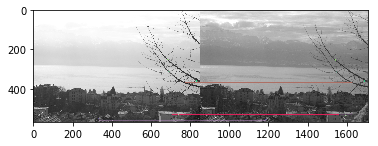

True

In [5]:
##  image registration
from registration import *
img_nir = registration(img_gray, img_nir_old, plot=True)
cv2.imwrite('output/branchview_nir_registered.png', img_nir)

## split images

In [6]:
from multiprocessing import Pool
##  parallel computations
n_jobs = 4
pool = Pool(processes=n_jobs)

from multiresolution_decomposition import *
##  create tiles
nir_and_rgb_stack = decompose(img_nir, tile_width, tile_height, padding)
rgb_stack = decompose(img_lum, tile_width, tile_height, padding)


for i in rgb_stack:
    nir_and_rgb_stack.append(i)
print('decomposed in {} patches.'.format(len(rgb_stack)))

decomposed in 54 patches.


## wls filter

In [7]:
##  analysis for each image
result = pool.map(multiresolution_analysis, nir_and_rgb_stack)

In [8]:
##  separate the results for the two images
nir_result = []
rgb_result = []
n_nir = len(rgb_stack)
for i, r in enumerate(result):
    if i < n_nir:
        nir_result.append(r)
    else:
        rgb_result.append(r)

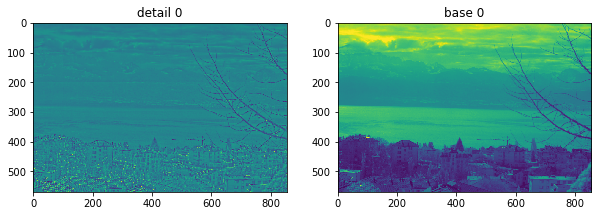

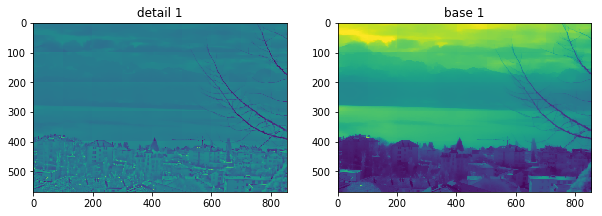

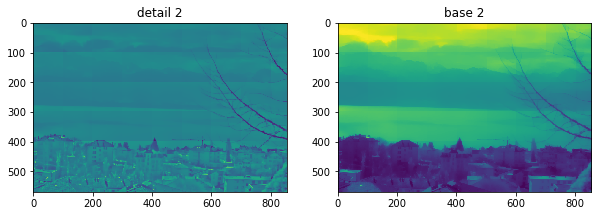

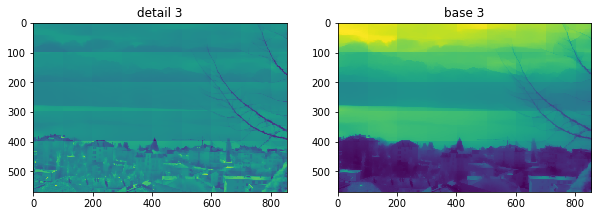

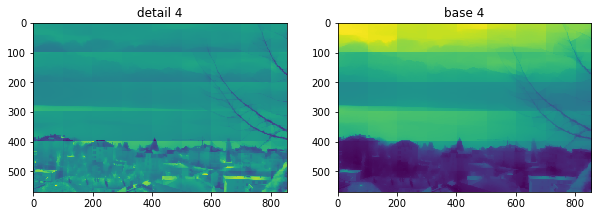

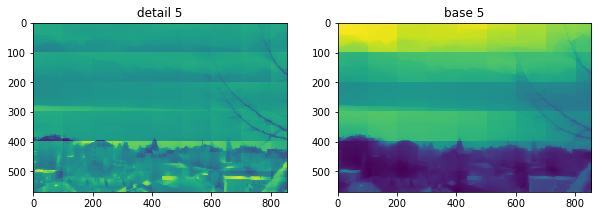

In [9]:
##  recombine the tiles in a complete image
K = 6
nir_details = [[] for k in range(K)]
nir_bases = [[] for k in range(K)]
for coarse_nir, detail_nir in nir_result:
    #nir_bases.append(base_nir)
    #print(stack_nir[0].shape)
    for k in range(K):
        nir_details[k].append(detail_nir[k])
        nir_bases[k].append(coarse_nir[k])
    
y, x = img_lum.shape
nir_detail = [[] for k in range(K)]
nir_base = [[] for k in range(K)]
for k in range(K):
    nir_detail[k] = recombine(nir_details[k], padding, x, y)
    nir_base[k] = recombine(nir_bases[k], padding, x, y)
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(10,20)
    ax[0].imshow(nir_detail[k])
    ax[0].set_title('detail {}'.format(k))
    ax[1].imshow(nir_base[k])
    ax[1].set_title('base {}'.format(k))
    plt.show()

## fuse images

In [10]:
##  prepare the arguments for the pixel fusion
args = []
for n, r in zip(nir_result, rgb_result):
    _, contrast = r
    _, contrast_nir = n
    args.append((contrast, contrast_nir))
    
from pixel_fusion import *
##  pixel fusion for every tile
fused_stack = pool.map(pixel_fusion, args)

##  prepare arguments for the synthesis
args = []
for r, f in zip(rgb_result, fused_stack):
    base, _ = r
    args.append((base, f))

## synthesize images

In [11]:
print('Synthesis')
##  synthesis for every tile
image_stack = pool.map(multiresolution_synthesis, args)

##  recombine the tiles in a complete image
x, y = img_lum.shape
image = recombine(image_stack, padding, x, y)

##  Keep the color from the original and write the result
img_rgb[..., 0] = np.round(image * 255)
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_LAB2RGB)
cv2.imwrite(dehazed_path, img_rgb)
print('Done')

Synthesis


ValueError: too many values to unpack (expected 2)